# Amazon Apparel Recommendation System 
     Based on the AppliedAI Course Workshop
     By Hariom Maurya
     february 2018
     --------------------------------------------------------------------------------------------------------------------

In [24]:
# Import some utility packages
import re
import os
import sys
import time

# Handle table like data and matrix
import pandas as pd
import numpy as np

# Ploting image
import PIL.Image
import requests
from io import BytesIO

# For handling some mathmetic stuff
from collections import Counter
import math

# Modeling Helper
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import pairwise_distances

# Data visualization
from matplotlib import gridspec
import seaborn as sns
from matplotlib import pyplot as plt
import plotly as py
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True) # for access plotly offline


# Loading 16k preprocessed data

In [25]:
data = pd.read_pickle("C:\\Users\harry\\Documents\\Untitled Folder\\project\\appliedAi\\pickels\\16k_apperal_data_preprocessed")

# Loading word2vec model

In [26]:
# From word2vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
with open("C:\\Users\harry\\Documents\\Untitled Folder\\project\\appliedAi\\word2vec_model", 'rb') as handle:
    model = pickle.load(handle)


# For creating idf word2vec vector for title

In [27]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [28]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [29]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [30]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

# One heart coding for brand and color feature

In [31]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

# Utility function for understanding algorithm decision

In [41]:
# Utility functions
#Display an image
import plotly
import plotly.figure_factory as ff
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)

def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

# Converting image into vector using vcc16

In [33]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load("C:\\Users\\harry\\Documents\\Untitled Folder\\project\\appliedAi\\16k_data_cnn_features.npy")
asins = np.load("C:\\Users\\harry\\Documents\\Untitled Folder\\project\\appliedAi\\16k_data_cnn_feature_asins.npy")
asins = list(asins)
# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

from IPython.display import display, Image, SVG, Math, YouTubeVideo

# idf weight word to vector model by title ,brand,color,image

welcome


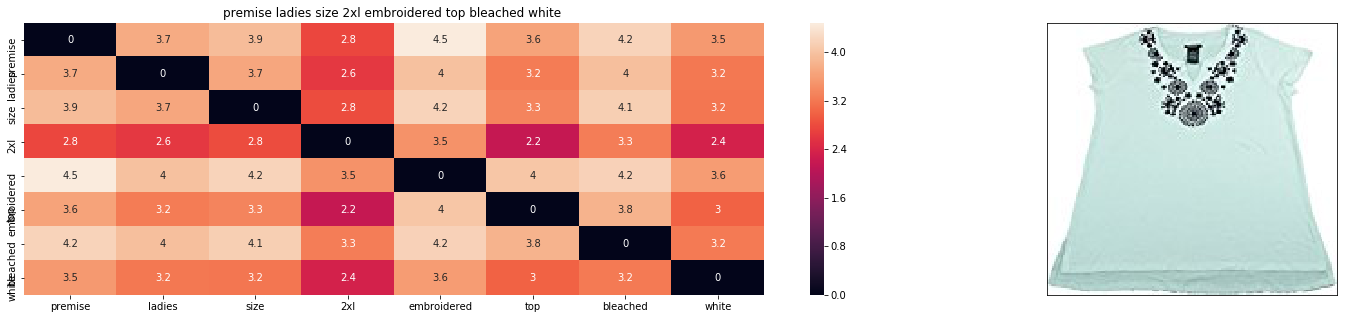

ASIN : B01M0IDUCV
Brand : Premise
euclidean distance from input : 2.46974921684
welcome


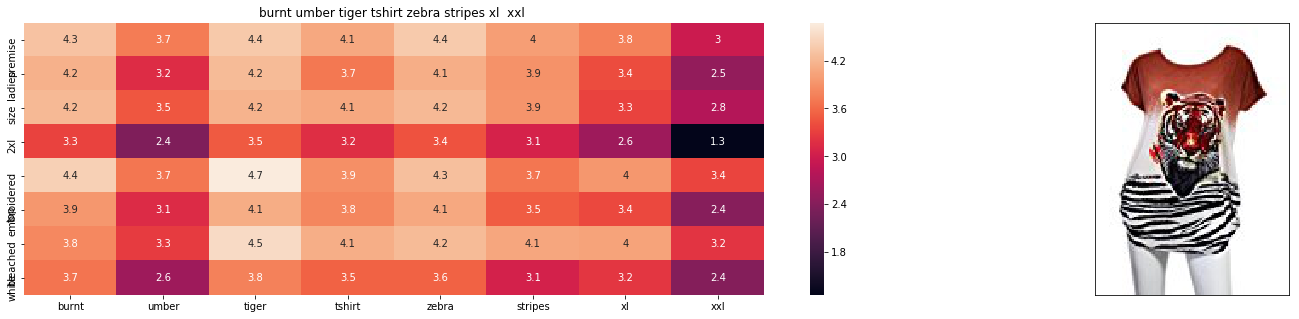

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 4.92185007731
welcome


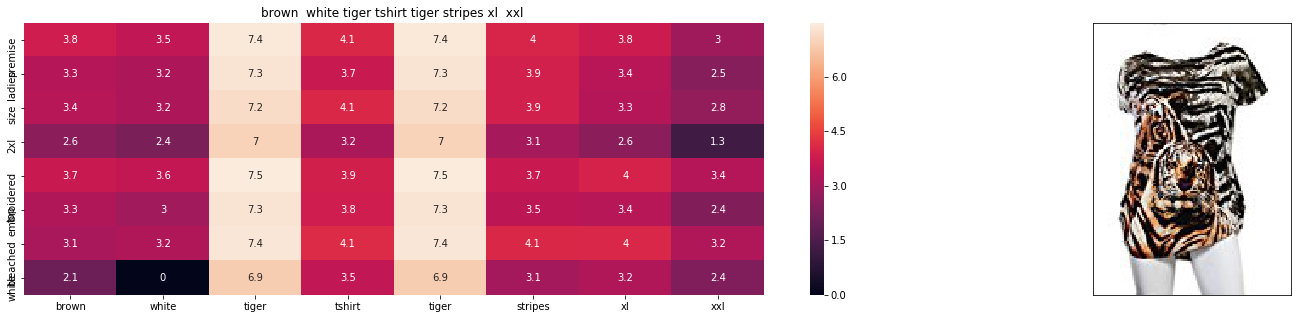

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 5.03679490089
welcome


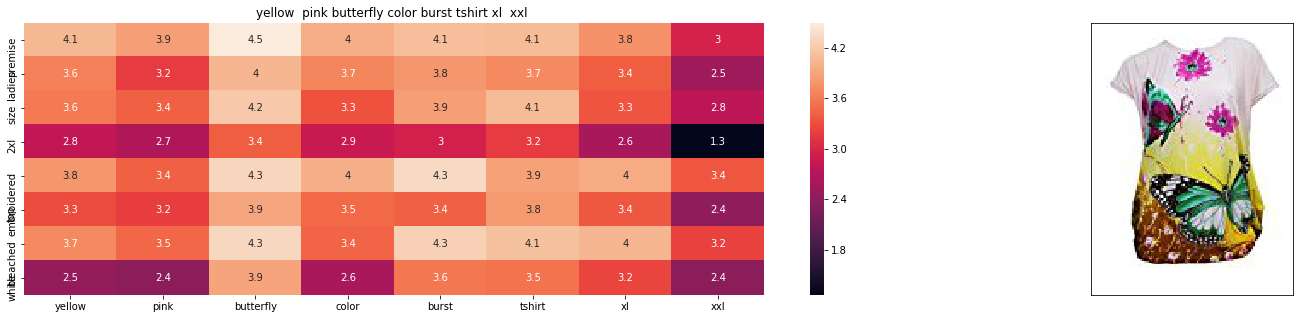

ASIN : B00JXQBBMI
Brand : Si Row
euclidean distance from input : 5.36526338289
welcome


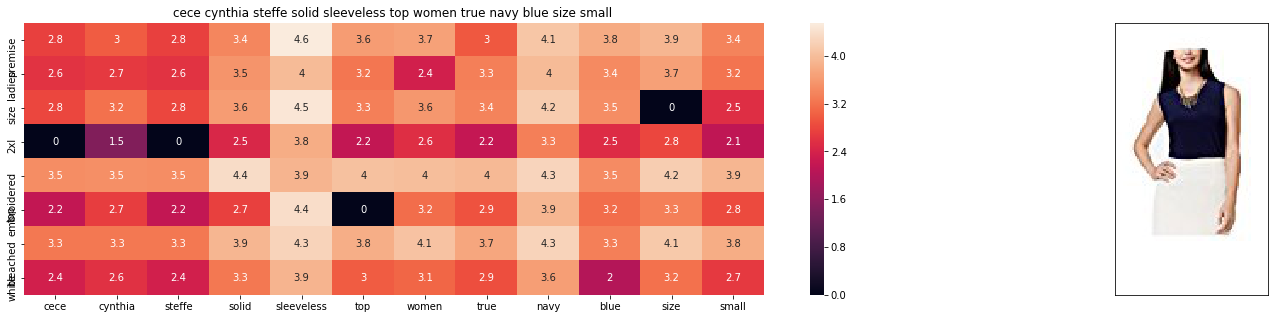

ASIN : B01N4NQ7LX
Brand : CeCe by Cynthia Steffe
euclidean distance from input : 5.38166502013
welcome


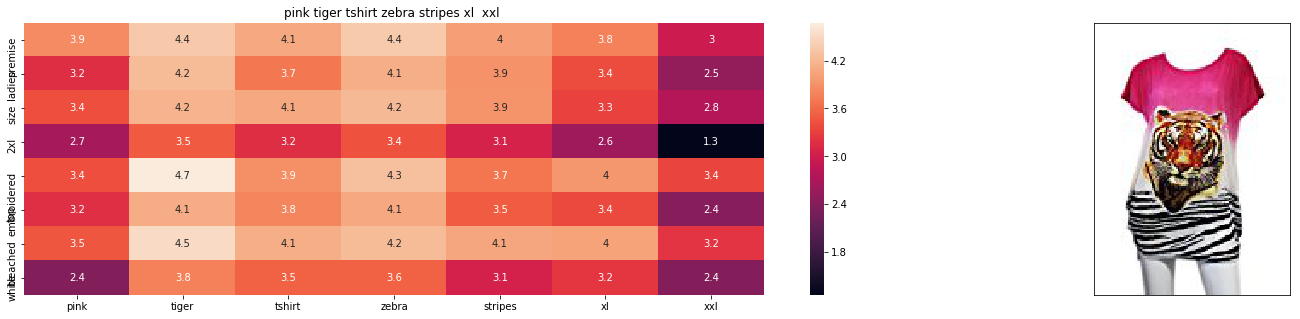

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 5.73381543587
welcome


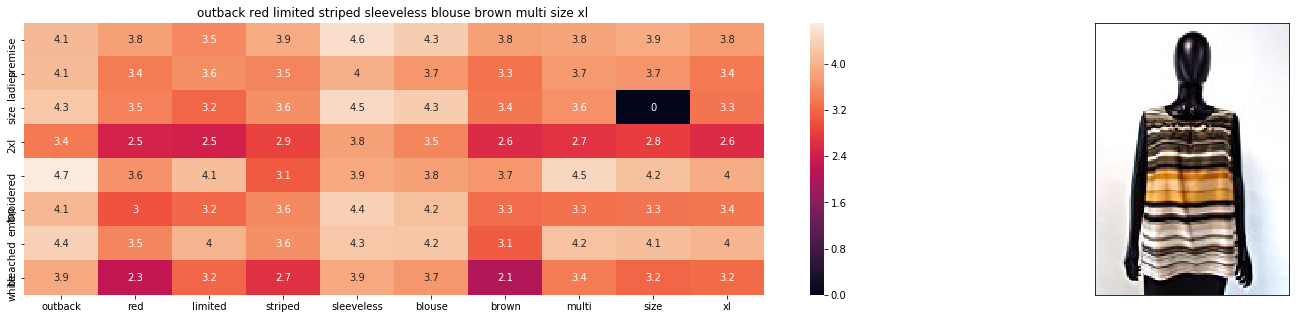

ASIN : B01IU645VU
Brand : Outback Red
euclidean distance from input : 5.7515500917
welcome


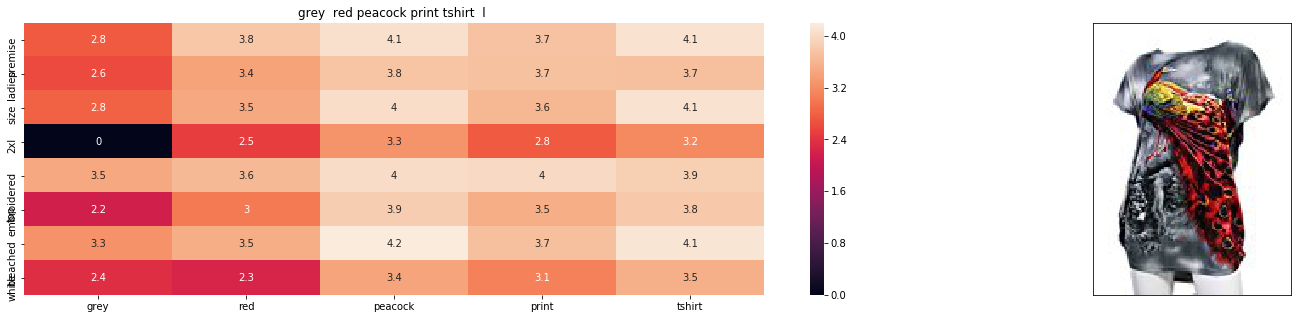

ASIN : B00JXQCFRS
Brand : Si Row
euclidean distance from input : 5.88368112276
welcome


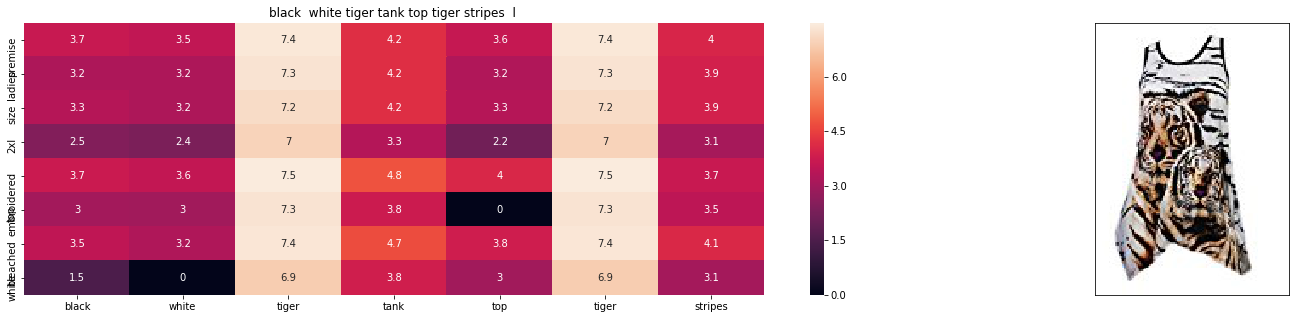

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 5.9151447617
welcome


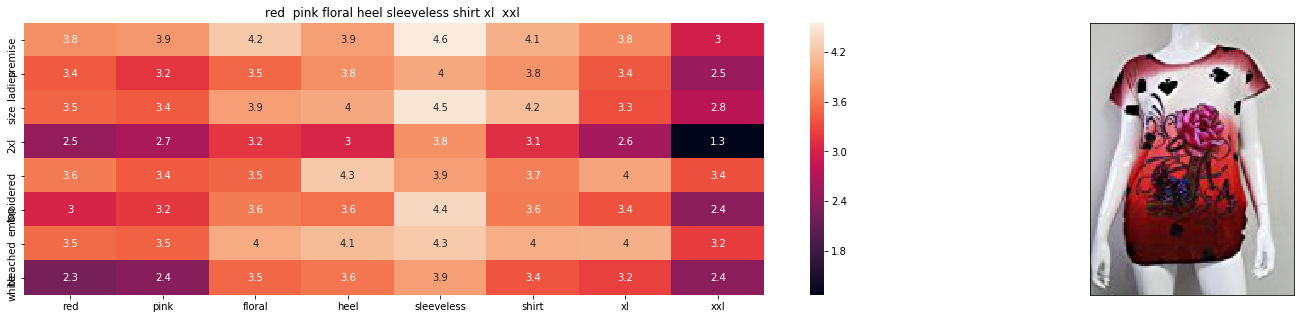

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from input : 5.98013897767
welcome


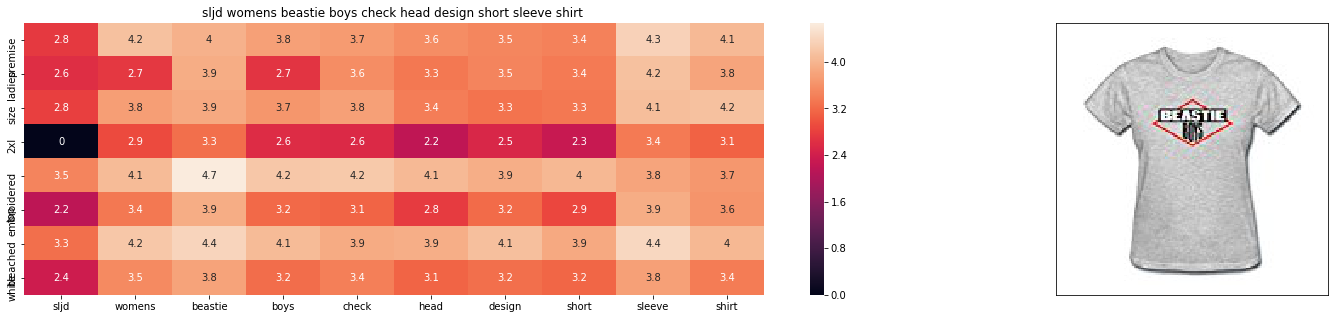

ASIN : B01FQLKKMK
Brand : SLJD
euclidean distance from input : 5.98416851898
welcome


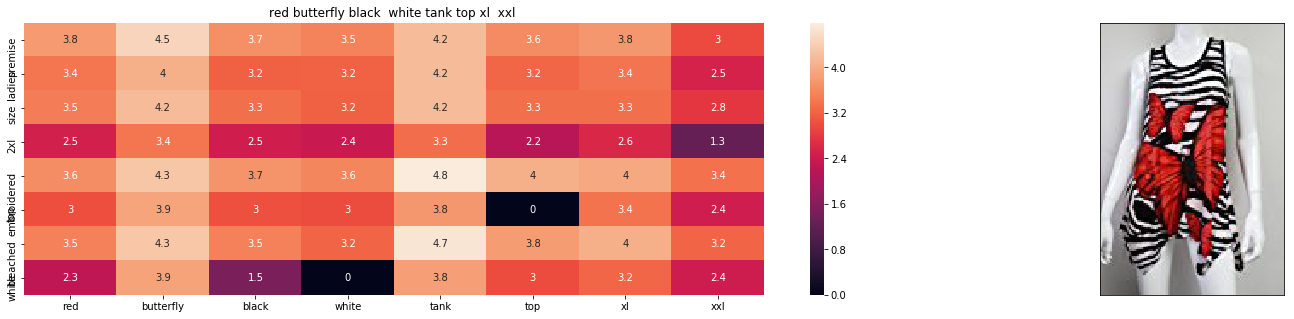

ASIN : B00JV63CW2
Brand : Si Row
euclidean distance from input : 6.06457014909
welcome


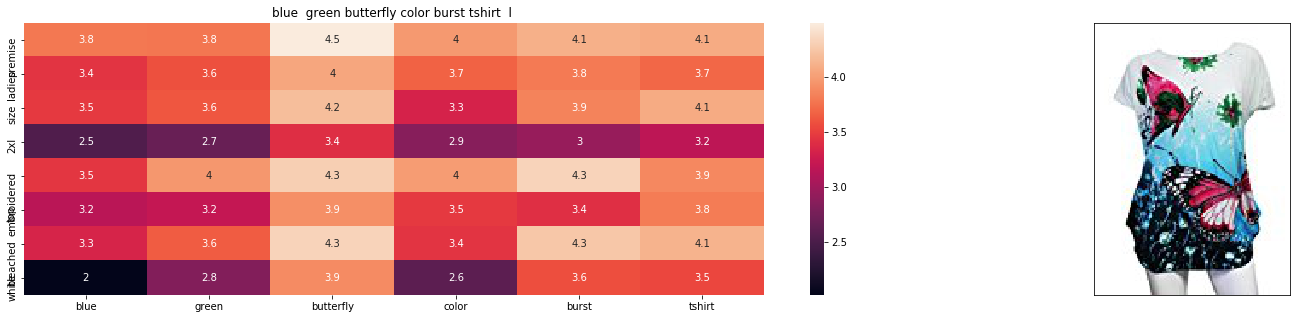

ASIN : B00JXQC0C8
Brand : Si Row
euclidean distance from input : 6.09472280373
welcome


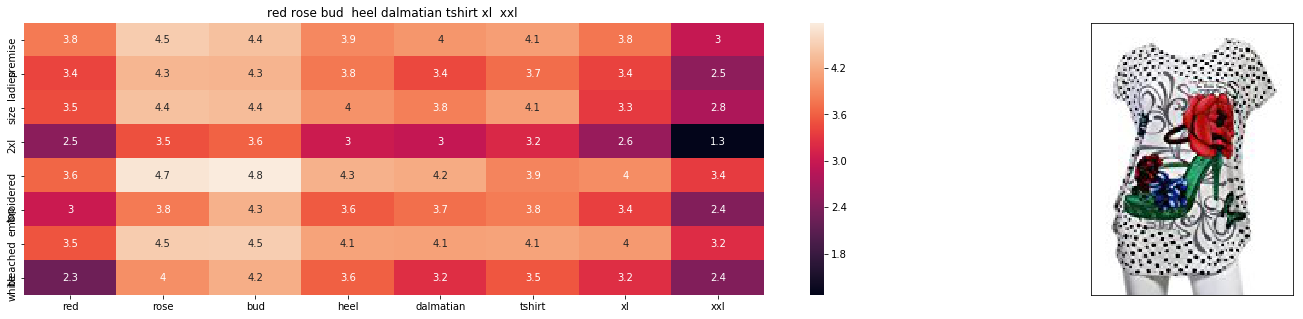

ASIN : B00JXQABB0
Brand : Si Row
euclidean distance from input : 6.09936908911
welcome


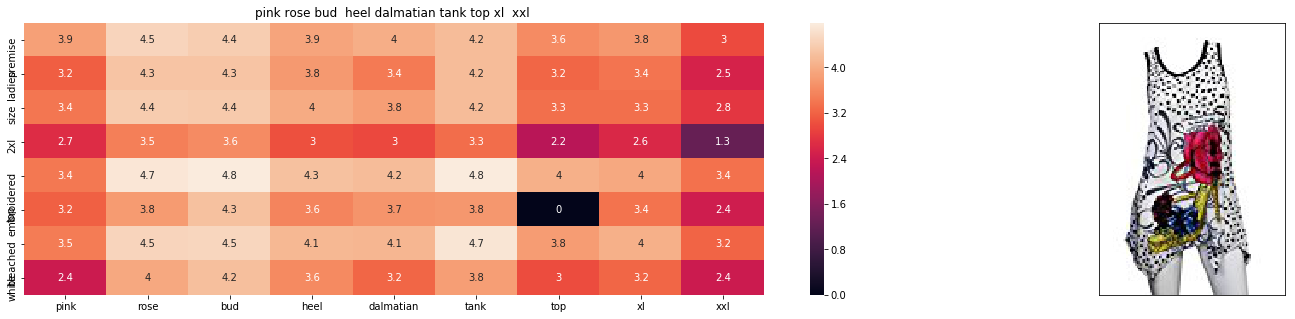

ASIN : B00JXQAX2C
Brand : Si Row
euclidean distance from input : 6.1453327182
welcome


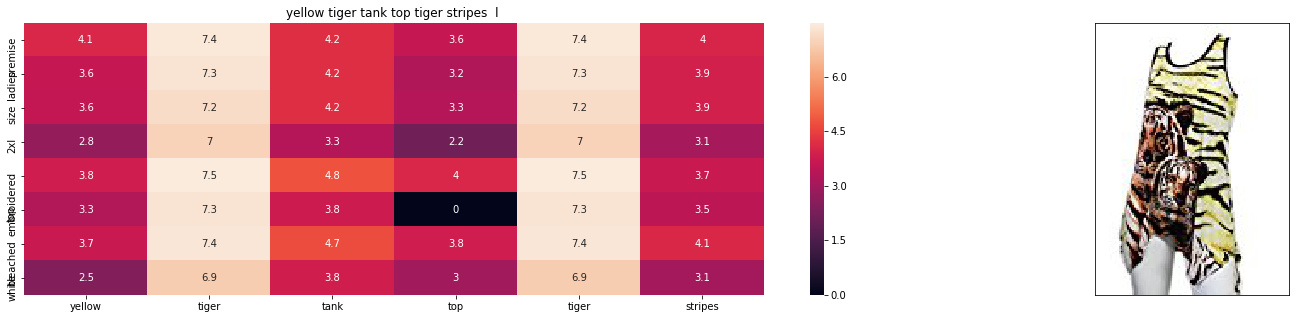

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 6.16384779642
welcome


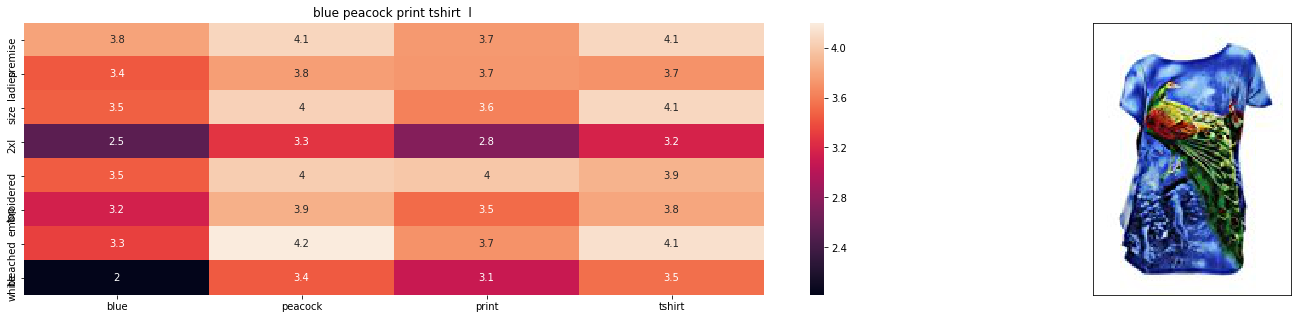

ASIN : B00JXQC8L6
Brand : Si Row
euclidean distance from input : 6.19027174344
welcome


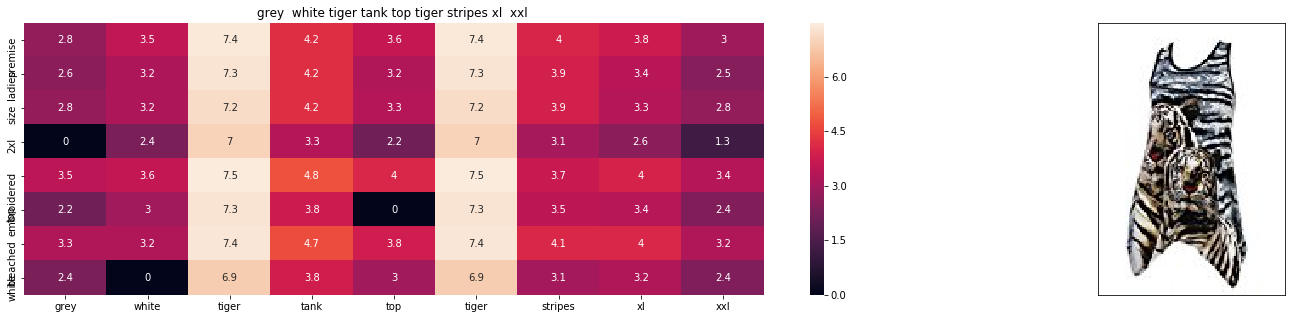

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 6.23054472636
welcome


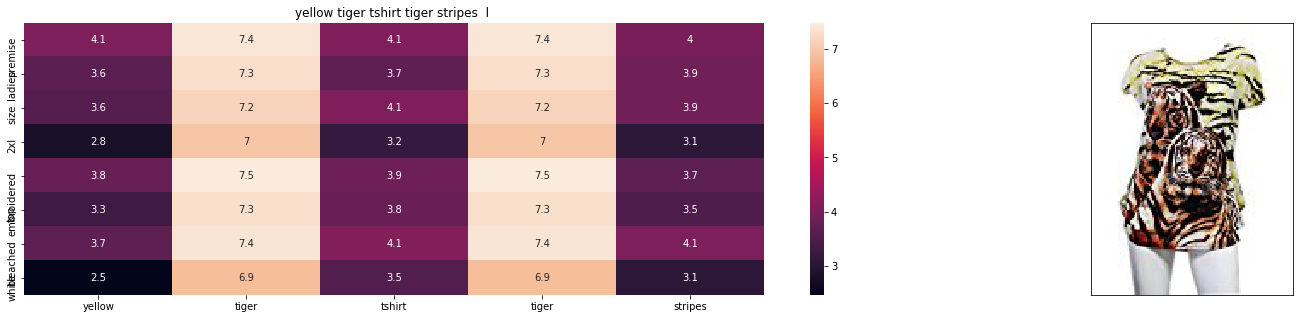

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 6.24871309628
welcome


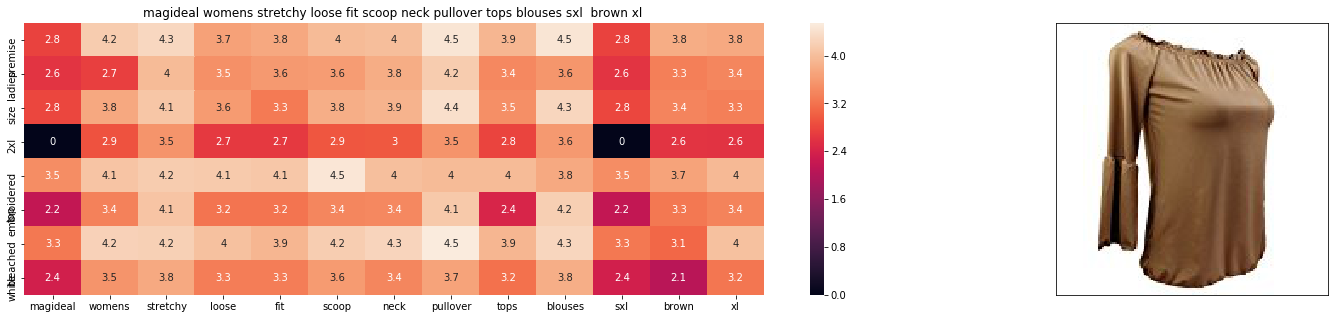

ASIN : B07515JFBF
Brand : MagiDeal
euclidean distance from input : 6.25605644033


In [40]:
def idf_w2v_model(doc_id, w1, w2,w3, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features
    # w3 : weight for image  

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    # for find id of query item
    doc_id_img = asins.index(df_asins[doc_id])
    # find pairwise distance between query item and other item by image
    img_vcc16_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id_img].reshape(1,-1))
    # find pairwise distance between query item and other item by title
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    # find pairwise distance between query item and other item by brand and color
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    #find weighted pairwise distance using given crossponding weight 
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist + w3 * img_vcc16_dist)/float(w1 + w2 + w3)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

idf_w2v_model(12566, 5, 50, 5, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j